1/1 [==============================] - 0s 47ms/step
Episode: 1, Total Reward: 0.9690362896590226
1/1 [==============================] - 0s 40ms/step
Episode: 2, Total Reward: 0.9549907793933836
1/1 [==============================] - 0s 31ms/step
Episode: 3, Total Reward: 0.5977721236579799
1/1 [==============================] - 0s 55ms/step
Episode: 4, Total Reward: 1.5971293127144301
1/1 [==============================] - 0s 83ms/step
Episode: 5, Total Reward: 1.8797442766248724
1/1 [==============================] - 0s 68ms/step
Episode: 6, Total Reward: 0.40633823437817884
1/1 [==============================] - 0s 86ms/step
Episode: 7, Total Reward: 0.36207850407721065
1/1 [==============================] - 0s 80ms/step
Episode: 8, Total Reward: 0.9543549324564614
1/1 [==============================] - 0s 63ms/step
Episode: 9, Total Reward: 0.6520582825789432
1/1 [==============================] - 0s 50ms/step
Episode: 10, Total Reward: 0.17573385200677372
1/1 [=====================

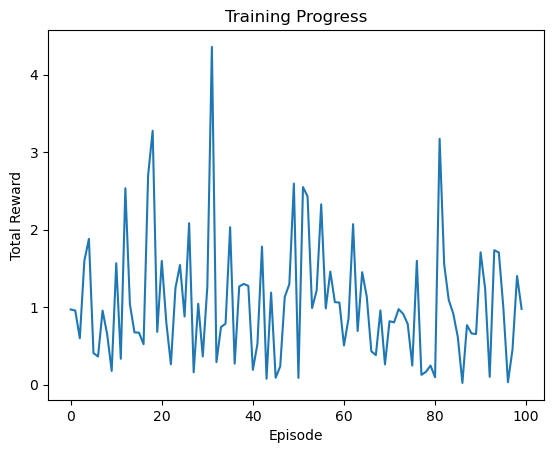

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random

# Define the Deep Q Network model
class DQN(models.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = layers.Dense(24, activation='relu', input_dim=state_size)
        self.fc2 = layers.Dense(24, activation='relu')
        self.output_layer = layers.Dense(action_size, activation='linear')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        return self.output_layer(x)

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Define the Deep Q Network Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(capacity=1000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def train(self, batch_size):
        if len(self.memory.buffer) < batch_size:
            return

        minibatch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = np.vstack(states)
        next_states = np.vstack(next_states)
        dones = np.array(dones, dtype=np.float32)  # Explicit conversion to NumPy array

        targets = rewards + self.gamma * (np.amax(self.target_model.predict(next_states), axis=1)) * (1.0 - dones)  # Use 1.0 instead of 1

        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            selected_action_values = tf.reduce_sum(tf.multiply(q_values, tf.one_hot(actions, self.action_size, dtype=tf.float32)), axis=1)
            loss = tf.keras.losses.MeanSquaredError()(targets, selected_action_values)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Synthetic dataset
def generate_synthetic_data(num_samples):
    state_size = 4
    action_size = 2

    states = np.random.rand(num_samples, state_size)
    actions = np.random.randint(action_size, size=num_samples)
    rewards = np.random.rand(num_samples)
    next_states = np.random.rand(num_samples, state_size)
    dones = np.random.choice([0.0, 1.0], size=num_samples).astype(np.float32)  # Use float values for dones

    return list(zip(states, actions, rewards, next_states, dones))






import matplotlib.pyplot as plt
# Function to visualize training progress
def plot_training_progress(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()
    
if __name__ == "__main__":
    state_size = 4
    action_size = 2
    num_episodes = 100
    batch_size = 32

    agent = DQNAgent(state_size, action_size)

    # Generate synthetic data and populate the replay buffer
    synthetic_data = generate_synthetic_data(500)
    for experience in synthetic_data:
        agent.memory.add(experience)

    total_rewards = []  # To store total rewards for each episode

    # Main training loop
    for episode in range(num_episodes):
        state = np.random.rand(1, agent.state_size)  # Initial state
        total_reward = 0

        while True:
            action = agent.act(state)
            next_state = np.random.rand(1, agent.state_size)
            reward = np.random.rand()
            done = np.random.choice([0, 1])

            agent.memory.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            agent.train(batch_size)

            if done:
                break

        agent.update_target_model()
        agent.decay_epsilon()

        total_rewards.append(total_reward)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    # Visualize the training progress
    plot_training_progress(total_rewards)

1/1 [==============================] - 0s 31ms/step


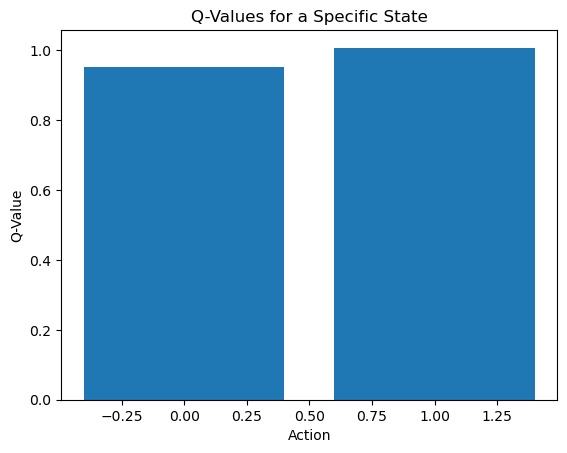

In [9]:
# After the training loop
state_to_visualize = np.random.rand(1, state_size)  # You can set this to a specific state
q_values_to_visualize = agent.model.predict(state_to_visualize)
plt.bar(range(action_size), q_values_to_visualize[0])
plt.xlabel('Action')
plt.ylabel('Q-Value')
plt.title('Q-Values for a Specific State')
plt.show()


1/1 [==============================] - 0s 31ms/step


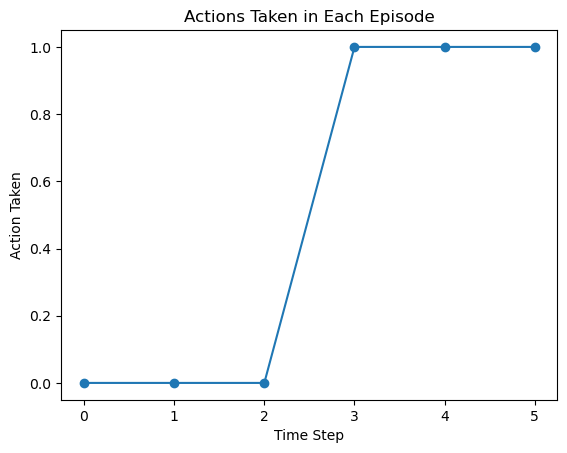

1/1 [==============================] - 0s 31ms/step


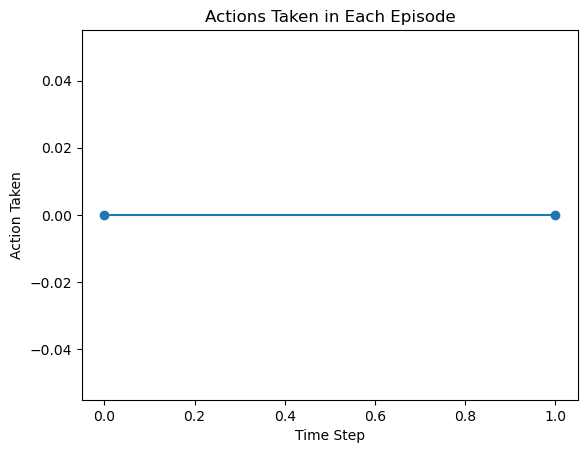

1/1 [==============================] - 0s 24ms/step


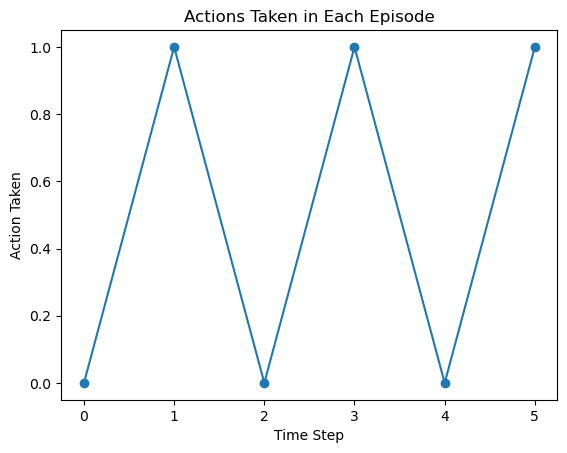

1/1 [==============================] - 0s 68ms/step


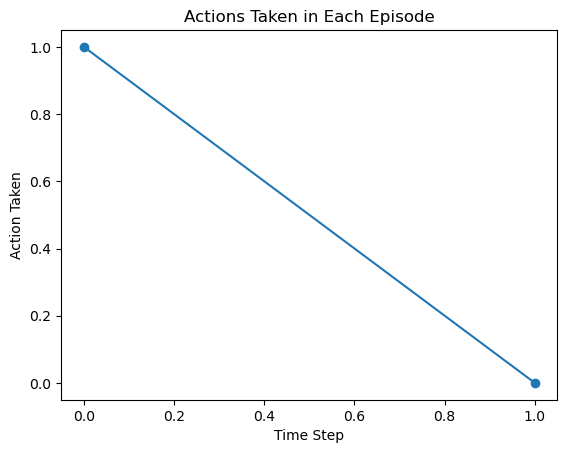

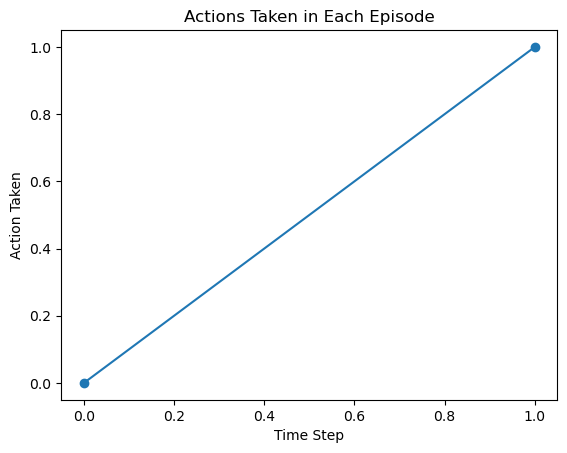

In [10]:
# After the training loop
def visualize_actions(agent, num_episodes=5):
    for _ in range(num_episodes):
        state = np.random.rand(1, state_size)
        episode_actions = []

        while True:
            action = agent.act(state)
            episode_actions.append(action)
            next_state = np.random.rand(1, state_size)
            state = next_state
            done = np.random.choice([0, 1])

            if done:
                break

        plt.plot(episode_actions, marker='o')
        plt.xlabel('Time Step')
        plt.ylabel('Action Taken')
        plt.title('Actions Taken in Each Episode')
        plt.show()

# Call the function to visualize actions
visualize_actions(agent)


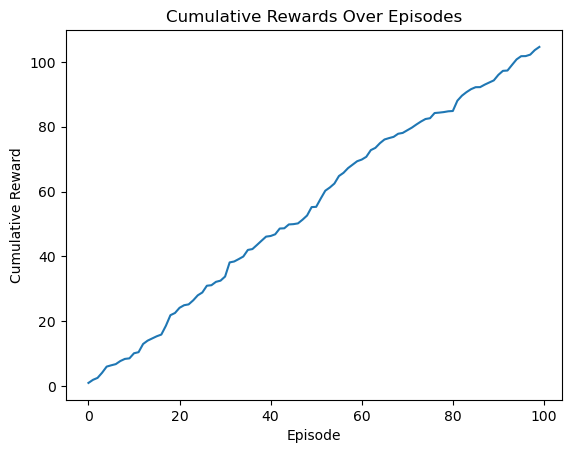

In [11]:
# After the training loop
def plot_cumulative_rewards(total_rewards):
    cumulative_rewards = np.cumsum(total_rewards)
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Over Episodes')
    plt.show()

# Call the function to visualize cumulative rewards
plot_cumulative_rewards(total_rewards)
